<h1>Fitting nova for flux template</h1>

In [1]:
# SPI model fitting with Stan
# Example: fitting two BG models + one nova model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan_utility
import pystan
import pickle
import sys
import time
from IPython.display import Image

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from angular_distance import angular_distance


from utils import make_bg_cuts
from utils import find_nearest

plt.style.use('thomas')

<h3>Reading in the data set</h3>

<h3>Pointing definition in pointin.fits file:</h3>

In [2]:
with fits.open('pointing_filter.fits.gz') as content:
    poin = content[1].data

Np = len(poin)
p = np.arange(Np)
print('Number of pointings in complete data set: ',Np)
Nrsp = 19 # 19 detectors
days = poin['TSTART']
revol_arr = np.array([float(poin['PTID_SPI'][i])/1e4 for i in range(Np)])

Number of pointings in complete data set:  99880


<h3>Data set (counts) in evts_det_spec.fits file:</h3>

In [3]:
with fits.open('evts_det_spec_filter.fits.gz') as content:
    evts = content[1].data
    
data = evts['COUNTS'][:,2].reshape(Np,Nrsp)

<h3>Energy boundaries definition (not important in our case, just illustration purpose):</h3>

In [4]:
with fits.open('energy_boundaries.fits.gz') as content:
    ebds = content[1].data

<h3>Detector dead time in dead_time.fits file:</h3>

In [5]:
with fits.open('dead_time_filter.fits.gz') as content:
    dead = content[1].data

<h3>Background model (already scaled to data) in back_model.fits file:</h3>

In [6]:
with fits.open('back_model.fits.gz') as content:
    bgc = content[2].data
    bgl = content[3].data

bgc_model = bgc['COUNTS'][:,2].reshape(Np,Nrsp)
bgl_model = bgl['COUNTS'][:,2].reshape(Np,Nrsp)

<h3>Complete INTEGRAL nova catalogue until 2018 (see earlier notebooks):</h3>

In [7]:
data_frame = pd.read_csv('INTEGRAL_novae_wTimes.csv')
good_novae = np.where(~np.isnan(data_frame['IJD']) &
                      (data_frame['Dist. \n(kpc)']+data_frame['Dist. Err. (kpc)'] < 25) &
                      ((data_frame['Var. type'] == 'N') |
                       (data_frame['Var. type'] == 'NAa') | 
                       (data_frame['Var. type'] == 'NB') |
                       (data_frame['Var. type'] == 'NC') |
                       (data_frame['Var. type'] == 'NTS')))[0]

<h3>These are our objects:</h3>

In [8]:
names = data_frame['Name'][good_novae].values
names

array(['V556 Nor', 'V3666 Oph', 'V613 Sct', 'V408 Lup', 'V5857 Sgr',
       'V435 CMa', 'V906 Car', 'V3665 Oph', 'V1663 Sco', 'V3664 Oph',
       'V1662 Sco', 'FM Cir', 'V1661 Sco', 'V357 Mus', 'V3663 Oph',
       'V1660 Sco', 'V549 Vel', 'V612 Sct', 'V1405 Cen', 'V3662 Oph',
       'V1657 Sco', 'V5856 Sgr', 'V5855 Sgr', 'V407 Lup', 'V1659 Sco',
       'V611 Sct', 'V1656 Sco', 'V5853 Sgr', 'V5854 Sgr ', 'V1655 Sco',
       'V555 Nor', 'V5850 Sgr', 'V2949 Oph', 'V1831 Aql', 'V5669 Sgr',
       'V2944 Oph', 'V1404 Cen', 'V1658 Sco', 'V1535 Sco', 'V5668 Sgr',
       'V2659 Cyg', 'V5666 Sgr', 'V1830 Aql', 'V556 Ser', 'V339 Del',
       'V1533 Sco', 'V809 Cep', 'V1724 Aql', 'V5593 Sgr', 'V5592 Sgr',
       'V959 Mon', 'V1324 Sco', 'V5589 Sgr', 'V5591 Sgr', 'V2676 Oph',
       'V965 Per', 'V1313 Sco', 'V5588 Sgr', 'V5587 Sgr', 'V1723 Aql ',
       'V5586 Sgr', 'V1310 Sco', 'V5585 Sgr', 'V2674 Oph', 'V2672 Oph',
       'V496 Sct', 'V5581 Sgr', 'V5582 Sgr', 'V5580 Sgr', 'V1212 Cen',
       'V1

<h3>And the corrresponding files:</h3>

In [9]:
!ls -l convskys/
# if that doesnt work, just look at the directory convskys

total 446856
-rw-r--r--  1 thomassiegert  staff   1694639 Jun 28 23:10 convsky_model_SPI_22Na_nova000_pointsource_V556_Nor.fits.gz
-rw-r--r--  1 thomassiegert  staff   2692869 Jun 28 23:10 convsky_model_SPI_22Na_nova001_pointsource_V3666_Oph.fits.gz
-rw-r--r--  1 thomassiegert  staff   2618913 Jun 28 23:10 convsky_model_SPI_22Na_nova002_pointsource_V613_Sct.fits.gz
-rw-r--r--  1 thomassiegert  staff   1699945 Jun 28 23:10 convsky_model_SPI_22Na_nova003_pointsource_V408_Lup.fits.gz
-rw-r--r--  1 thomassiegert  staff   2603190 Jun 28 23:09 convsky_model_SPI_22Na_nova004_pointsource_V5857_Sgr.fits.gz
-rw-r--r--  1 thomassiegert  staff    375330 Jun 28 23:10 convsky_model_SPI_22Na_nova005_pointsource_V435_CMa.fits.gz
-rw-r--r--  1 thomassiegert  staff    789360 Jun 28 23:10 convsky_model_SPI_22Na_nova006_pointsource_V906_Car.fits.gz
-rw-r--r--  1 thomassiegert  staff   2778410 Jun 28 23:10 convsky_model_SPI_22Na_nova007_pointsource_V3665_Oph.fits.gz
-rw-r--r--  1 thomassiegert  staff   276

<h3>You see that they are in the same order and have a certain index associated with them, so e.g., convsky_model_SPI_22Na_nova004_pointsource_V5857_Sgr.fits.gz has the index 4 (the first 4 [0..3] are always zero because they happen after the last pointing of our data set):</h3>

In [10]:
filename = 'convsky_model_SPI_22Na_nova004_pointsource_V5857_Sgr.fits.gz'
ndx = 4
print('Source name: ',names[ndx])

Source name:  V5857 Sgr


<h3>Always check that this works out as expected.</h3>

<h3>Smaller indices are later times (thus, smaller data sets):</h3>

In [11]:
# explosion date
T0 = data_frame['IJD'][good_novae].values[ndx]
print('Explosion date [IJD]: ',T0)

# decay constant
tau = 2.602/np.log(2)*365.25
#print(tau)

Explosion date [IJD]:  6672.7229976851895


<h3>We read in the already-convolved sky model response of chosen nova:</h3>

In [12]:
with fits.open('convskys/'+filename) as content:
    nova = content[2].data
    
nova_model = nova['COUNTS'].reshape(Np,Nrsp)

<h3>Expectation for significance (check later if this ~worked out)</h3>

In [13]:
# summing over all detectors (axis=1)
flux_scl = 2e2
nova_counts_time = np.nansum(nova_model/flux_scl,axis=1) # /2e2 to make 2e-3 to 1e-5
# applying exponential decay function
nova_counts_decay = nova_counts_time*np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau)

<h3>Cross check expected counts</h3>

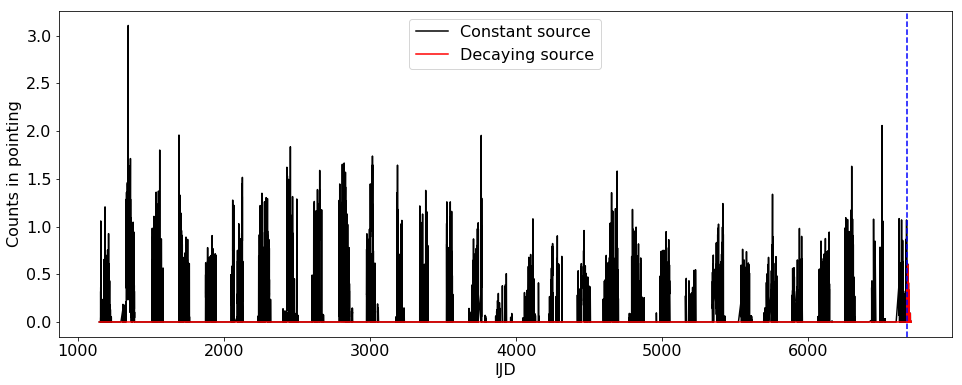

In [14]:
plt.figure(figsize=(16,6))
plt.plot(days,nova_counts_time,label='Constant source')
plt.plot(days,nova_counts_decay,label='Decaying source')
plt.axvline(T0,linestyle='--',color='blue')
plt.xlabel('IJD')
plt.ylabel('Counts in pointing')
plt.legend()
#plt.xlim(T0,)

In [15]:
# same for the data to get total counts in each pointing
data_counts_time = np.sum(data,axis=1)
# remember SNR from last notebook
# decaying source
snr_nova_decay = np.sqrt(np.nancumsum((nova_counts_decay / np.sqrt(data_counts_time))**2))
# constant source
snr_nova_const = np.sqrt(np.nancumsum((nova_counts_time / np.sqrt(data_counts_time))**2))

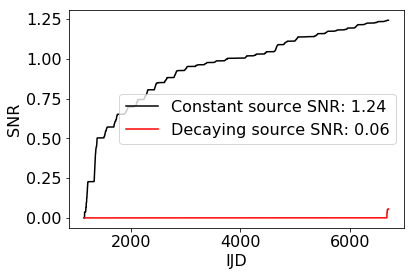

In [16]:
plt.plot(days,snr_nova_const,label='Constant source SNR: '+str('%.2f' % snr_nova_const[-1]))
plt.plot(days,snr_nova_decay,label='Decaying source SNR: '+str('%.2f' % snr_nova_decay[-1]))
plt.xlabel('IJD')
plt.ylabel('SNR')
plt.legend()
plt.savefig('SNR_expectation'+names[ndx]+'.pdf')

In [17]:
livetime = dead['livetime'].reshape(Np,Nrsp)

<h3>Load Stan model</h3>

In [18]:
try:
    #read filename.pkl (if already compiled)
    model = pickle.load(open('spimodfit_bg_conti_sep_nozeros.pkl', 'rb'))

except:
    print('Stan model not yet compiled, doing that now')
    ## compile model (if not yet compiled):
    model = pystan.StanModel('spimodfit_bg_conti_sep_nozeros.stan')

    ## save it to the file 'filename.pkl' for later use
    with open('spimodfit_bg_conti_sep_nozeros.pkl', 'wb') as f:
        pickle.dump(model, f)

<h3>Using useful cuts for the background:</h3>

<h3>Typically, background changes on the time scale of one orbit. Thus, we want to find the indices where a new INTEGRAL revolution starts, etc.:</h3>

In [19]:
revolutions, rev_idx = np.unique(np.floor(revol_arr),return_index=True)
rev_idx += 1 #+1 for stan
det_failures_IJD = np.array([1435.41635,1659.46000,3337.50000,3799.66740])
df_idx = np.array([find_nearest(poin['TSTART'],i) for i in det_failures_IJD])
df_idx[np.where(poin['TSTART'][df_idx] < det_failures_IJD)[0]] += 1
df_idx += 1 #+1 for stan

annealing_revs = np.array([40,94,134,207,279,328,397,449,508,568,644,717,
                           799,860,913,978,1044,1115,1180,1251,1321,1374,
                           1452,1509,1587,1654,1707,1773,1845,1915])
ann_idx_tmp = np.array([find_nearest(revolutions,i) for i in annealing_revs])
ann_idx_tmp[np.where(revolutions[ann_idx_tmp] < annealing_revs)[0]] += 1
ann_idx_tmp += 1 #Stan
ann_idx_tmp = np.delete(ann_idx_tmp,0) # get rid of the first entry as already included in the revolution indices
ann_idx = np.array([rev_idx[np.where(revolutions == revolutions[ann_idx_tmp[i]-1])[0][0]] for i in range(len(ann_idx_tmp))])

every_x_rev = [1,2]
all_cuts_rev = [list(rev_idx[::i]) for i in every_x_rev]
all_cuts_unique_rev = np.unique(all_cuts_rev)
all_cuts = [list(all_cuts_unique_rev[i])+list(df_idx)+list(ann_idx) for i in range(len(all_cuts_unique_rev))]
all_cuts.append(list(df_idx)+list(ann_idx))
all_cuts.append(list(df_idx))
all_cuts.append(list([1]))
all_cuts_unique = np.array([list(dict.fromkeys(cuts)) for cuts in all_cuts])

<h3>Now reformatting our model:</h3>

In [20]:
nova_model_decay = nova_model*(np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau))[:,None]/flux_scl

In [21]:
# first index
fidx = np.where(nova_model_decay[:,0] != 0)[0][0]
print('first non-zero index: ',fidx)

# new pointings
Np_decay = Np-fidx # number of pointings in reduced data set
print('Number of remaining pointings: ',Np_decay)

# new cuts
cuts_decay = np.array(all_cuts_unique[0])[np.array(all_cuts_unique[0])>=(fidx+1)]-(fidx)

first non-zero index:  99296
Number of remaining pointings:  584


<h3>Now building everything together as before, but now with the reduced data set:</h3>

In [22]:
# background cuts 
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1]+list(cuts_decay),Np_decay)

# good indices
idx = np.where(~((data[fidx:,:].ravel() == 0) &
                 (bgl_model[fidx:,:].ravel() == 0) &
                 (bgc_model[fidx:,:].ravel() == 0)))[0] + 1

# number of good (non-zero) indices
Ngood = len(idx)

mu_flux_scl = np.array([0.])      # prior centroids for sky, we use 0 because we expect to see nothing
sigma_flux_scl = np.array([100.]) # width very broad (noninformative now) because we let the data talk
mu_Abg_lines = 1.                      # background as before
sigma_Abg_lines = 0.2                  # same
mu_Abg_conti = 1.                      # same
sigma_Abg_conti = 0.1                  # same


# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_decay,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = data[fidx:,:].ravel().astype(int),
              bg_model_lines = np.abs(bgl_model[fidx:,:]),
              bg_model_conti = np.abs(bgc_model[fidx:,:]),
              conv_sky = nova_model_decay[fidx:,:].reshape(1,Np_decay,Nrsp), 
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

# init for specific cuts
init = {}
init['flux'] = np.array([1.0])
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)

# optimize for test run
start = time.time()
op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)

0.1163170337677002


<h3>If this runs without throwing an error, then we fit:</h3>

In [23]:
# sample full posterior
start = time.time()
fit_tmp = model.sampling(data=data2D,
                         chains=1,
                         iter=1000,
                         n_jobs=-1,
                         verbose=True,
                         pars=['flux','Abg_lines','Abg_conti'])
print(time.time()-start)

85.18616199493408


<h3>Check ouput and print the StanSummary for the flux value:</h3>

In [24]:
print(fit_tmp.stansummary(['flux']))

Inference for Stan model: anon_model_82974d80982aabf2b11051a2be36db84.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   13.8     0.4   9.79   1.08   5.64  11.93   19.4  37.78    591    1.0

Samples were drawn using NUTS at Fri Jul 31 21:38:52 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h3>Plot posterior distribution of all values and save to pdf:</h3>

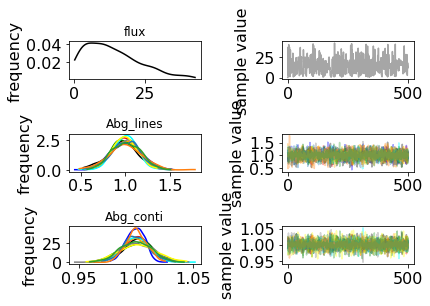

In [25]:
fit_tmp.plot(['flux','Abg_lines','Abg_conti'])
plt.tight_layout()
plt.savefig('posteriors_'+names[ndx]+'.pdf')

<h3>Print out the info we want (upper bound):</h3>

In [26]:
print('Upper bound (99.85th percentile) on the 22Na (1275 keV) flux of '+data_frame['Name'][good_novae[ndx]]+': %.1fe-5' % (np.percentile(fit_tmp['flux'],99.85)))

Upper bound (99.85th percentile) on the 22Na (1275 keV) flux of V5857 Sgr: 42.0e-5


<h3>Checking our expectation from above:</h3>

In [27]:
# maximum SNR for flux of 1e-5:
SNR_max = snr_nova_decay[-1]

# 3sigma bound wrt to this value:
print('Expected 3sigma limit: %.1fe-5' % (3/SNR_max))

Expected 3sigma limit: 53.7e-5


<h3>This value should be in the ballpart of the one above (factor of 2), then we are good to go.</h3>

<h3>Save fit info to file:</h3>

In [28]:
np.savez_compressed('save_StanFit_Nova'+data_frame['Name'][good_novae[ndx]]+'.npz',
                    fit_tmp_flux=fit_tmp['flux'],
                    fit_tmp_Abg_conti=fit_tmp['Abg_conti'],
                    fit_tmp_Abg_lines=fit_tmp['Abg_lines'])

<h3>Done, next source.</h3>

<h1>List of objects for everyone:</h1>

<h3>Akshay:</h3>

In [32]:
print('Objects: ',names[::5])
print('Indices: ',np.arange(len(names))[::5])

Objects:  ['V556 Nor' 'V435 CMa' 'V1662 Sco' 'V1660 Sco' 'V1657 Sco' 'V611 Sct'
 'V555 Nor' 'V2944 Oph' 'V2659 Cyg' 'V1533 Sco' 'V959 Mon' 'V965 Per'
 'V5586 Sgr' 'V496 Sct' 'V1721 Aql' 'V5579 Sgr' 'V598 Pup' 'V2576 Oph'
 'V5115 Sgr' 'DE Cir' 'V2540 Oph']
Indices:  [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


<h3>Sohan:</h3>

In [34]:
print('Objects: ',names[1::5])
print('Indices: ',np.arange(len(names))[1::5])

Objects:  ['V3666 Oph' 'V906 Car' 'FM Cir' 'V549 Vel' 'V5856 Sgr' 'V1656 Sco'
 'V5850 Sgr' 'V1404 Cen' 'V5666 Sgr' 'V809 Cep' 'V1324 Sco' 'V1313 Sco'
 'V1310 Sco' 'V5581 Sgr' 'V679 Car' 'NR TrA' 'V1280 Sco' 'V5117 Sgr'
 'V5116 Sgr' 'DZ Cru' 'V4743 Sgr']
Indices:  [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101]


<h3>Ethan:</h3>

In [35]:
print('Objects: ',names[2::5])
print('Indices: ',np.arange(len(names))[2::5])

Objects:  ['V613 Sct' 'V3665 Oph' 'V1661 Sco' 'V612 Sct' 'V5855 Sgr' 'V5853 Sgr'
 'V2949 Oph' 'V1658 Sco' 'V1830 Aql' 'V1724 Aql' 'V5589 Sgr' 'V5588 Sgr'
 'V5585 Sgr' 'V5582 Sgr' 'V2468 Cyg' 'V1065 Cen' 'V5558 Sgr' 'V1047 Cen'
 'V574 Pup' 'V475 Sct']
Indices:  [ 2  7 12 17 22 27 32 37 42 47 52 57 62 67 72 77 82 87 92 97]


<h3>Kalp:</h3>

In [36]:
print('Objects: ',names[3::5])
print('Indices: ',np.arange(len(names))[3::5])

Objects:  ['V408 Lup' 'V1663 Sco' 'V357 Mus' 'V1405 Cen' 'V407 Lup' 'V5854 Sgr '
 'V1831 Aql' 'V1535 Sco' 'V556 Ser' 'V5593 Sgr' 'V5591 Sgr' 'V5587 Sgr'
 'V2674 Oph' 'V5580 Sgr' 'V2491 Cyg' 'V2467 Cyg' 'V458 Vul' 'V382 Nor'
 'V1186 Sco' 'V5113 Sgr']
Indices:  [ 3  8 13 18 23 28 33 38 43 48 53 58 63 68 73 78 83 88 93 98]


<h3>Thomas:</h3>

In [37]:
print('Objects: ',names[4::5])
print('Indices: ',np.arange(len(names))[4::5])

Objects:  ['V5857 Sgr' 'V3664 Oph' 'V3663 Oph' 'V3662 Oph' 'V1659 Sco' 'V1655 Sco'
 'V5669 Sgr' 'V5668 Sgr' 'V339 Del' 'V5592 Sgr' 'V2676 Oph' 'V1723 Aql '
 'V2672 Oph' 'V1212 Cen' 'QY Mus' 'V2615 Oph' 'V459 Vul' 'V476 Sct'
 'V1187 Sco' 'V4744 Sgr']
Indices:  [ 4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79 84 89 94 99]
